In [1]:
cd /content/drive/MyDrive/Colab Notebooks/kaggle

/content/drive/MyDrive/Colab Notebooks/kaggle


In [2]:
!nvidia-smi

Sun Jun  6 18:35:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/kaggle'

In [4]:
cd ANIME\ GAN

/content/drive/MyDrive/Colab Notebooks/kaggle/ANIME GAN


In [ ]:
# !kaggle datasets download -d soumikrakshit/anime-faces

In [ ]:
# !unzip anime-faces.zip && rm -f anime-faces.zip

In [ ]:
ls

data/  Generated/  Untitled0.ipynb


In [5]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from tensorflow import keras
import tensorflow as tf
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam

(64, 64, 3)


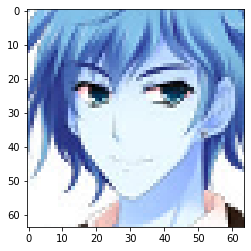

In [7]:
img = cv2.imread(f'data/data/9074.png')
print(img.shape)
plt.imshow(img)

In [8]:
physical_devices = tf.config.list_physical_devices("GPU")
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
dataset = keras.preprocessing.image_dataset_from_directory(
    directory='data/data', 
    label_mode=None, 
    image_size=(64, 64), 
    batch_size=128,
    shuffle=True
    ).map(lambda x: x/255.)

Found 21550 files belonging to 1 classes.


In [11]:
latent_dim = 100
gen_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

In [12]:
generator = Sequential()
generator.add(Input(shape=(latent_dim, )))

generator.add(Dense(4*4*512))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
generator.add(Reshape((4, 4, 512)))

generator.add(Conv2DTranspose(filters=256, kernel_size=5, padding="same", strides=2, use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

generator.add(Conv2DTranspose(filters=128, kernel_size=5, padding="same", strides=2, use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

generator.add(Conv2DTranspose(filters=64, kernel_size=5, padding="same", strides=2, use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

generator.add(Conv2DTranspose(filters=32, kernel_size=5, padding="same", strides=2, use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

generator.add(Conv2D(filters=3, kernel_size=5, padding="same", strides=1))
generator.add(Activation('sigmoid'))

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

In [14]:
discriminator = Sequential()
discriminator.add(Input(shape=(64, 64, 3)))

discriminator.add(Conv2D(filters=64, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))

discriminator.add(Conv2D(filters=128, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))

discriminator.add(Conv2D(filters=256, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))

discriminator.add(Conv2D(filters=512, kernel_size=5, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [15]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)        

In [16]:
#mkdir Generated

In [ ]:
ls

In [17]:
for i in range(50):
    print('epoch: ', i)
    for idx, real_imgs in enumerate(dataset):
        print(".", end="")
        batch_size = real_imgs.shape[0]
        random_latent_vec = tf.random.normal(shape=(batch_size, latent_dim))
        fake_imgs = generator(random_latent_vec)
        fake_labels = tf.zeros((batch_size, 1))
        if idx == 100:
            fig, axs = plt.subplots(4, 2, figsize=(15, 15))
            cnt = 0
            for x in range(4):
                for y in range(2):
                    axs[x, y].axis('off')
                    axs[x, y].imshow(fake_imgs[cnt])
                    cnt += 1
            fig.savefig(f'Generated/epoch={i}.png')
            plt.close()
        with tf.GradientTape() as disc_f:
            preds = discriminator(fake_imgs)
            disc_loss_f = loss_fn(fake_labels, preds)
        grads = disc_f.gradient(disc_loss_f, discriminator.trainable_weights)
        disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as disc_r:
            preds = discriminator(real_imgs)
            disc_loss_r = loss_fn(labels, preds)
        grads = disc_r.gradient(disc_loss_r, discriminator.trainable_weights)
        disc_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        random_latent_vec = tf.random.normal(shape=(batch_size, latent_dim))
        incorrect_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gen:
            preds = discriminator(generator(random_latent_vec))
            gen_loss = loss_fn(incorrect_labels, preds)
        grads = gen.gradient(gen_loss, generator.trainable_weights)
        gen_optimizer.apply_gradients(zip(grads, generator.trainable_weights))
    
    print()
    print(f"Disc Loss Real: [{disc_loss_r}]\nDisc Loss Fake: [{disc_loss_f}]\nGen Loss: [{gen_loss}]")
    print()

epoch:  0
.........................................................................................................................................................................
Disc Loss Real: [0.3208388090133667]
Disc Loss Fake: [0.48748132586479187]
Gen Loss: [2.751859664916992]

epoch:  1
.........................................................................................................................................................................
Disc Loss Real: [0.3406306505203247]
Disc Loss Fake: [0.21032652258872986]
Gen Loss: [2.2369399070739746]

epoch:  2
.........................................................................................................................................................................
Disc Loss Real: [0.4094364643096924]
Disc Loss Fake: [0.28408288955688477]
Gen Loss: [3.119483709335327]

epoch:  3
...................................................................................................................................

In [18]:
ls

data/  Generated/  Untitled0.ipynb


In [19]:
cd Generated

/content/drive/My Drive/Colab Notebooks/kaggle/ANIME GAN/Generated


In [20]:
ls

'epoch=0.png'   'epoch=19.png'  'epoch=28.png'  'epoch=37.png'  'epoch=46.png'
'epoch=10.png'  'epoch=1.png'   'epoch=29.png'  'epoch=38.png'  'epoch=47.png'
'epoch=11.png'  'epoch=20.png'  'epoch=2.png'   'epoch=39.png'  'epoch=48.png'
'epoch=12.png'  'epoch=21.png'  'epoch=30.png'  'epoch=3.png'   'epoch=49.png'
'epoch=13.png'  'epoch=22.png'  'epoch=31.png'  'epoch=40.png'  'epoch=4.png'
'epoch=14.png'  'epoch=23.png'  'epoch=32.png'  'epoch=41.png'  'epoch=5.png'
'epoch=15.png'  'epoch=24.png'  'epoch=33.png'  'epoch=42.png'  'epoch=6.png'
'epoch=16.png'  'epoch=25.png'  'epoch=34.png'  'epoch=43.png'  'epoch=7.png'
'epoch=17.png'  'epoch=26.png'  'epoch=35.png'  'epoch=44.png'  'epoch=8.png'
'epoch=18.png'  'epoch=27.png'  'epoch=36.png'  'epoch=45.png'  'epoch=9.png'


25


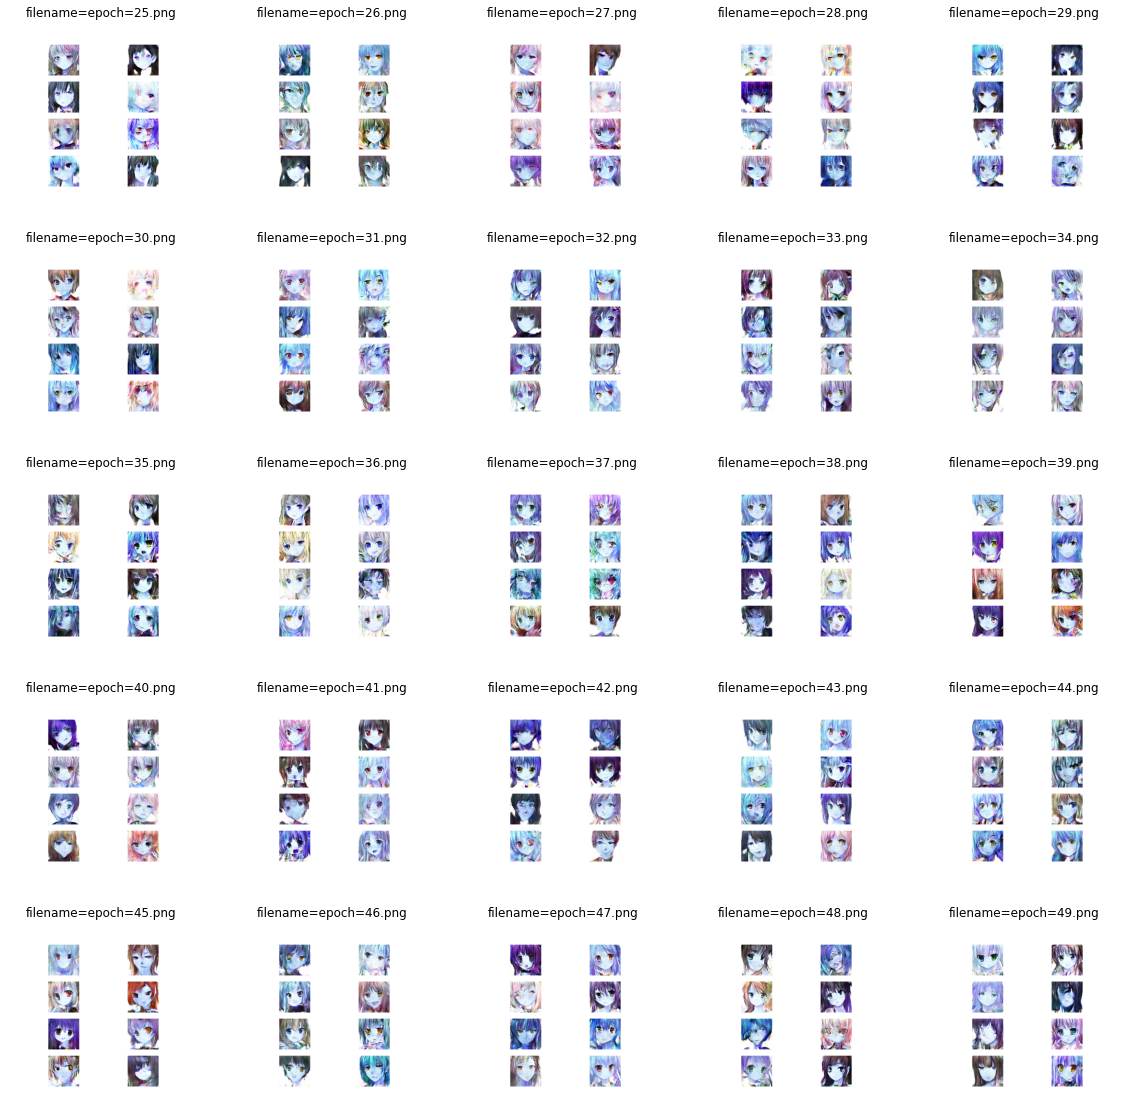

In [23]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
fnames = os.listdir()[25:]
print(len(fnames))
cnt = 0
for i in range(5):
    for j in range(5):
        img = cv2.imread(fnames[cnt])
        ax[i][j].axis('off')
        ax[i][j].set_title(f'filename={fnames[cnt]}')
        ax[i][j].imshow(img)
        cnt += 1
plt.show()